# Deep Q-Network for Atari Breakout.

In this assignment you are required to implement a Deep Q-Network agent, for the Atari game Breakout.

You need to submit your code, along with a plot of the rewards during training, and a video of an episode with the trained agent.


**Submitters:**

Najah Kamal - 325829133

Salam Qais - 327876116

__Frameworks__ - we'll accept this homework in any deep learning framework. This particular notebook was designed for PyTorch, but you'll find it easy to adapt it to almost any Python-based deep learning framework.

In [81]:
!pip install setuptools==65.5.0 "wheel<0.40.0"
!pip install stable-baselines3[extra] ale-py==0.7.4 gym==0.21.0
!pip install pyglet==1.5.27
!pip install pyvirtualdisplay

In [82]:
import os
import random
import numpy as np
import torch
import gym
import numpy as np
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display

if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !apt-get -qq install -y xvfb
    os.environ['DISPLAY'] = ':1'

display = Display(visible=0, size=(400, 300))
display.start()


## Breakout

This is an environment emulating the Atari game *Breakout*. The goal is to break all the bricks in the wall without letting the ball touch the floor. You have 5 lives and get points more points for higher brick than for the lower ones.

The observation is an image with dimensions (210, 160, 3).

There are 4 actions defined as NOOP, FIRE, LEFT and RIGHT.

See full description [here](https://www.gymlibrary.dev/environments/atari/breakout/).




observation dim (210, 160, 3) number of actions 4


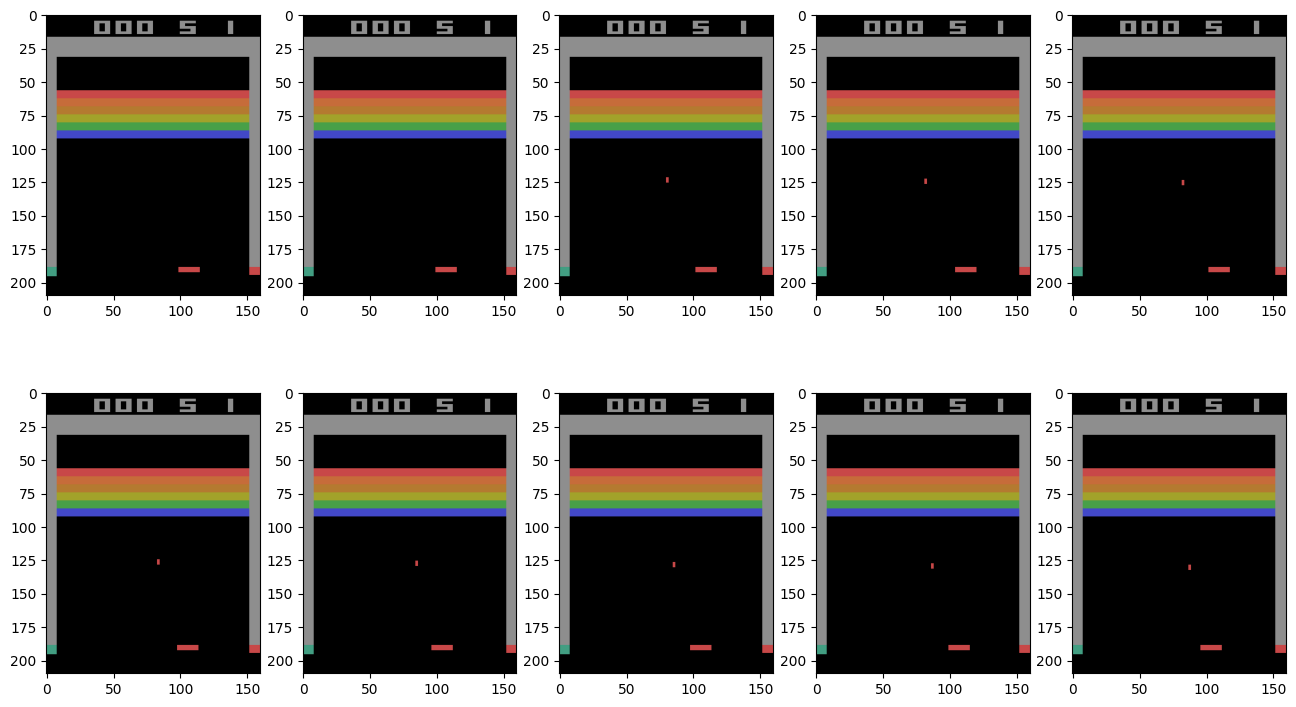

In [83]:
ENV_NAME = "BreakoutNoFrameskip-v4"
env = gym.make(ENV_NAME)
obs = env.reset()

n_actions = env.action_space.n
obs_dim = obs.shape
print("observation dim", obs_dim, "number of actions", n_actions)


n_cols = 5
n_rows = 2
fig = plt.figure(figsize=(16, 9))

for row in range(n_rows):
    for col in range(n_cols):
        ax = fig.add_subplot(n_rows, n_cols, row * n_cols + col + 1)
        ax.imshow(obs)
        ax.imshow(env.render('rgb_array'))
        env.step(env.action_space.sample())
plt.show()

## Wrappers

In order to make the environment more suitable for RL training, we make the following updates to the environment, using environment wrappers:
1. Preprocess the images to contain only the relevant part of the image, converted to grayscale. The raw images are large and we can do with 64x64 images.
2. Concatenate the 4 previous images (in order to capture dynamics)
3. Start the fire action automatically when starting the episode
4. Repeat the same action for 4 time steps
5. Output the maximum values of the last 2 frames per pixel (in order to prevent blinking)
6. Ouput a "done" signal every time a life is reduced but only reset the environment when all lives are gone
7. Bin the rewards to the values {-1, 0, 1}




In [84]:
from gym.core import Wrapper
from gym.spaces.box import Box
from gym.core import ObservationWrapper
from gym.spaces import Box
import cv2

class PreprocessAtariObs(ObservationWrapper):
    def __init__(self, env):
        """A gym wrapper that crops, scales image into the desired shapes and grayscales it."""
        ObservationWrapper.__init__(self, env)

        self.img_size = (1, 64, 64)
        self.observation_space = Box(0.0, 1.0, self.img_size)


    def observation(self, img):
        """what happens to each observation"""

        #  * crop image, remove irrelevant parts
        #  * resize image to self.img_size
        #  * cast image to grayscale
        #  * convert image pixels to (0,1) range, float32 type
        img = img[34:-16, 8:-8, :]
        img = cv2.resize(img, self.img_size[1:])
        img = (img*np.array([[[0.8, .1, .1]]])).sum(-1, keepdims=True)  # grayscale with more weight for red (accelerates training)
        img = img.astype('float32') / 255.
        return img.transpose((2, 0, 1))

class MaxAndSkipEnv(gym.Wrapper):
    def __init__(self, env, skip=4):
        """Return only every `skip`-th frame"""
        gym.Wrapper.__init__(self, env)
        # most recent raw observations (for max pooling across time steps)
        self._obs_buffer = np.zeros(
            (2,) + env.observation_space.shape, dtype=np.uint8)
        self._skip = skip

    def step(self, action):
        """Repeat action, sum reward, and max over last observations."""
        total_reward = 0.0
        done = None
        for i in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            if i == self._skip - 2:
                self._obs_buffer[0] = obs
            if i == self._skip - 1:
                self._obs_buffer[1] = obs
            total_reward += reward
            if done:
                break
        # Note that the observation on the done=True frame
        # doesn't matter
        max_frame = self._obs_buffer.max(axis=0)

        return max_frame, total_reward, done, info

    def reset(self, **kwargs):
        return self.env.reset(**kwargs)

class ClipRewardEnv(gym.RewardWrapper):
    def __init__(self, env):
        gym.RewardWrapper.__init__(self, env)

    def reward(self, reward):
        """Bin reward to {+1, 0, -1} by its sign."""
        return np.sign(reward)

class FireResetEnv(gym.Wrapper):
    def __init__(self, env):
        """Take action on reset for environments that are fixed until firing."""
        gym.Wrapper.__init__(self, env)
        assert env.unwrapped.get_action_meanings()[1] == 'FIRE'
        assert len(env.unwrapped.get_action_meanings()) >= 3

    def reset(self, **kwargs):
        self.env.reset(**kwargs)
        obs, _, done, _ = self.env.step(1)
        if done:
            self.env.reset(**kwargs)
        obs, _, done, _ = self.env.step(2)
        if done:
            self.env.reset(**kwargs)
        return obs

    def step(self, ac):
        return self.env.step(ac)

class EpisodicLifeEnv(gym.Wrapper):
    def __init__(self, env):
        """Make end-of-life == end-of-episode, but only reset on true game over.
        Done by DeepMind for the DQN and co. since it helps value estimation.
        """
        gym.Wrapper.__init__(self, env)
        self.lives = 0
        self.was_real_done = True

    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        self.was_real_done = done
        # check current lives, make loss of life terminal,
        # then update lives to handle bonus lives
        lives = self.env.unwrapped.ale.lives()
        if lives < self.lives and lives > 0:
            # for Qbert sometimes we stay in lives == 0 condition for a few frames
            # so it's important to keep lives > 0, so that we only reset once
            # the environment advertises done.
            done = True
        self.lives = lives
        return obs, reward, done, info

    def reset(self, **kwargs):
        """Reset only when lives are exhausted.
        This way all states are still reachable even though lives are episodic,
        and the learner need not know about any of this behind-the-scenes.
        """
        if self.was_real_done:
            obs = self.env.reset(**kwargs)
        else:
            # no-op step to advance from terminal/lost life state
            obs, _, _, _ = self.env.step(0)
        self.lives = self.env.unwrapped.ale.lives()
        return obs

def PrimaryAtariWrap(env, clip_rewards=True):
    assert 'NoFrameskip' in env.spec.id

    # This wrapper holds the same action for <skip> frames and outputs
    # the maximal pixel value of 2 last frames (to handle blinking
    # in some envs)
    env = MaxAndSkipEnv(env, skip=4)

    # This wrapper sends done=True when each life is lost
    # (not all the 5 lives that are givern by the game rules).
    # It should make easier for the agent to understand that losing is bad.
    env = EpisodicLifeEnv(env)

    # This wrapper laucnhes the ball when an episode starts.
    # Without it the agent has to learn this action, too.
    # Actually it can but learning would take longer.
    env = FireResetEnv(env)

    # This wrapper transforms rewards to {-1, 0, 1} according to their sign
    if clip_rewards:
        env = ClipRewardEnv(env)

    # This wrapper preprocesses observations
    env = PreprocessAtariObs(env)
    return env

class FrameBuffer(Wrapper):
    def __init__(self, env, n_frames=4, dim_order='tensorflow'):
        """A gym wrapper that reshapes, crops and scales image into the desired shapes"""
        super(FrameBuffer, self).__init__(env)
        self.dim_order = dim_order
        if dim_order == 'tensorflow':
            height, width, n_channels = env.observation_space.shape
            obs_shape = [height, width, n_channels * n_frames]
        elif dim_order == 'pytorch':
            n_channels, height, width = env.observation_space.shape
            obs_shape = [n_channels * n_frames, height, width]
        else:
            raise ValueError(
                'dim_order should be "tensorflow" or "pytorch", got {}'.format(dim_order))
        self.observation_space = Box(0.0, 1.0, obs_shape)
        self.framebuffer = np.zeros(obs_shape, 'float32')

    def reset(self):
        """resets breakout, returns initial frames"""
        self.framebuffer = np.zeros_like(self.framebuffer)
        self.update_buffer(self.env.reset())
        return self.framebuffer

    def step(self, action):
        """plays breakout for 1 step, returns frame buffer"""
        new_img, reward, done, info = self.env.step(action)
        self.update_buffer(new_img)
        return self.framebuffer, reward, done, info

    def update_buffer(self, img):
        if self.dim_order == 'tensorflow':
            offset = self.env.observation_space.shape[-1]
            axis = -1
            cropped_framebuffer = self.framebuffer[:, :, :-offset]
        elif self.dim_order == 'pytorch':
            offset = self.env.observation_space.shape[0]
            axis = 0
            cropped_framebuffer = self.framebuffer[:-offset]
        self.framebuffer = np.concatenate(
            [img, cropped_framebuffer], axis=axis)


def make_env(clip_rewards=True, seed=None):
    env = gym.make(ENV_NAME)  # create raw env
    if seed is not None:
        env.seed(seed)
    env = PrimaryAtariWrap(env, clip_rewards)
    env = FrameBuffer(env, n_frames=4, dim_order='pytorch')
    return env

env = make_env()
env.reset()
n_actions = env.action_space.n
state_shape = env.observation_space.shape

## Check observations under wrappers

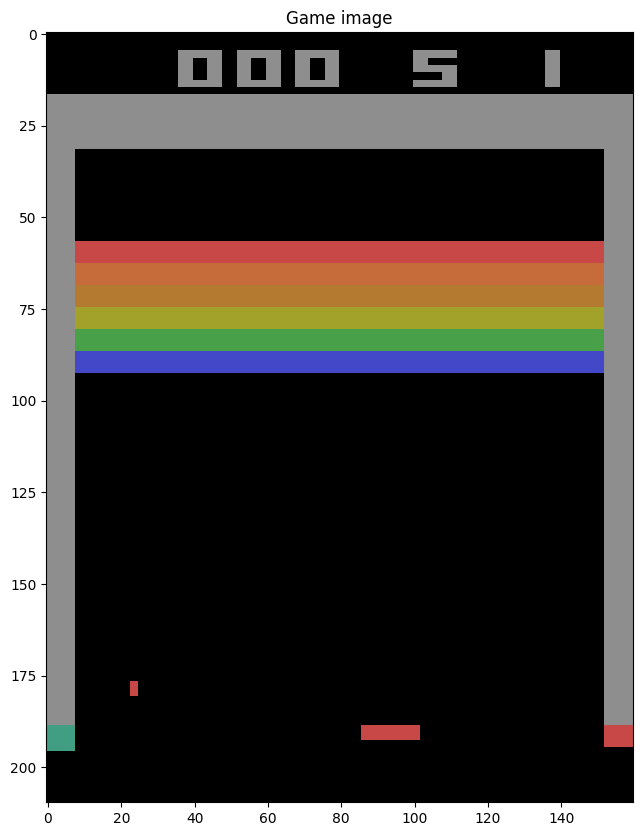

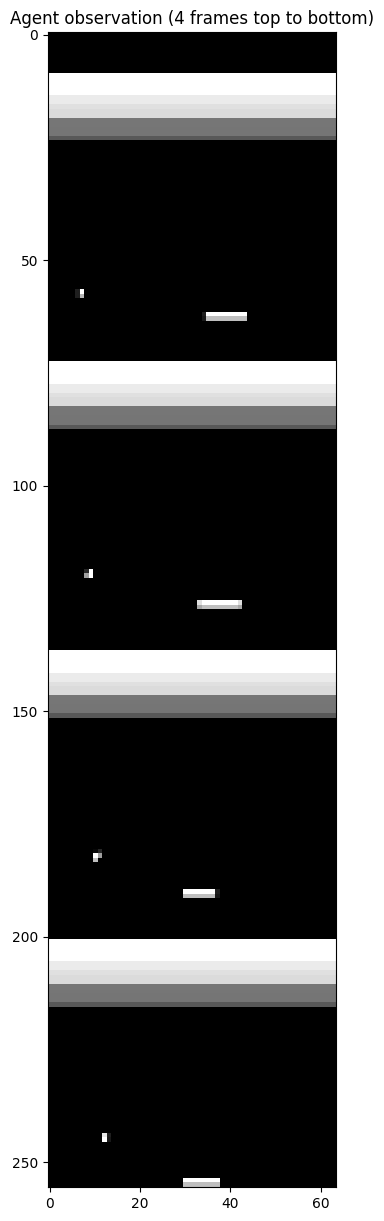

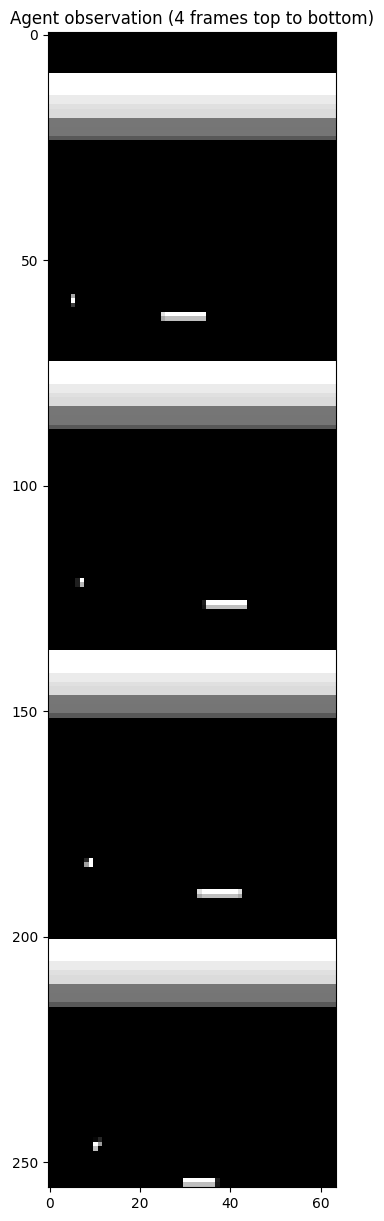

In [85]:
for _ in range(12):
    obs, _, _, _ = env.step(env.action_space.sample())

plt.figure(figsize=[12,10])
plt.title("Game image")
plt.imshow(env.render("rgb_array"))
plt.show()

plt.figure(figsize=[15,15])
plt.title("Agent observation (4 frames top to bottom)")
plt.imshow(obs.reshape([-1, state_shape[2]]), cmap='gray')
obs, _, _, _ = env.step(env.action_space.sample())
plt.figure(figsize=[15,15])
plt.title("Agent observation (4 frames top to bottom)")
plt.imshow(obs.reshape([-1, state_shape[2]]), cmap='gray')
plt.show()

## Random Agent

Here we implement a random agent to use in the 'evaluate' function, that runs the agent through multiple epsiodes.

In [87]:
class RandomAgent():
    def __init__(self, n_actions):
        self.n_actions = n_actions


    def get_qvalues(self, states):
        return np.random.normal(size=(1,self.n_actions,))

    def sample_actions(self, qvalues):
        return np.random.randint(self.n_actions, size=(1,))

In [88]:
def evaluate(env, agent, n_games=1, greedy=True, t_max=10000):
    """ Plays n_games full games. If greedy, picks actions as argmax(qvalues). Returns mean reward. """
    rewards = []
    for _ in range(n_games):
        s = env.reset()
        reward = 0
        for _ in range(t_max):
            qvalues = agent.get_qvalues(torch.from_numpy(s).unsqueeze(0)).squeeze(0).numpy()
            action = qvalues.argmax(axis=-1) if greedy else agent.sample_actions(qvalues)[0]
            s, r, done, _ = env.step(action)
            reward += r
            if done:
              break

        rewards.append(reward)
    return np.mean(rewards)

## Assignment

Implement a DQN agent that contains:
1. A neural network that predicts the q-values for a given observation.
2. An experience replay buffer where all transitions are added.
3. A target Q-network that is formed by periodically copying the weights of the main Q-nework.

You will also need to implement the training loop, and submit a figure showing the reward as a function of the training step, and a video showing an episode with the trained agent.

### Agent and Training loop

In [89]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from torch.optim import Adam
import random
from shutil import move
import os
from collections import deque
n_actions = env.action_space.n

In [92]:
# Global parameters

n_actions = env.action_space.n
n_obs = 16384
max_steps = 1000000
batch_size = 32
max_buffer_size = 80000
discount = 0.99
learning_rate = 0.00025
tau = 0.0005

epsilon = 1
MIN_EPS = 0.1

random_frames = 50000
exploration_frames = 1000000

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [93]:
class DQN(nn.Module):

  def __init__(self, n_obs , n_actions):
    super(DQN, self).__init__()
    self.conv1 = nn.Conv2d(4, 32, kernel_size=3, stride=2)
    self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2)
    self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=2)
    self.fc1 = nn.Linear(3136, 256)
    self.fc2 = nn.Linear(256, n_actions)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    x = F.relu(self.conv3(x))
    x = F.relu(self.fc1(x.view(x.size(0), -1)))

    return self.fc2(x)

In [94]:
class Agent:

  def __init__(self, n_actions, epsilon):
    self.n_actions = n_actions
    self.epsilon = epsilon
    self.policy_DQN = DQN(n_obs, n_actions).to(device)

  def get_qvalues(self, states):
    with torch.no_grad():
      return self.policy_DQN(states)

  def step(self, env_state):
    rand = random.random()
    state = torch.from_numpy(env_state).to(device)
    if(rand < self.epsilon):
      return np.random.randint(self.n_actions)
    else:
      with torch.no_grad():
        return self.policy_DQN(state.unsqueeze(0)).squeeze(0).argmax(axis=-1).item()


In [95]:
class Train_Break_Out:

  def __init__(self, env, n_obs, n_actions, device):
    self.env = env
    self.device = device
    self.agent = Agent(n_actions, epsilon)

    self.replay_buffer = []
    self.index = 0
    self.frames_cnt = 0
    self.episodes_reward_list = []

    self.target_DQN = DQN(n_obs, n_actions).to(device)
    self.target_DQN.load_state_dict(self.agent.policy_DQN.state_dict())
    self.optimizer = torch.optim.Adam(self.agent.policy_DQN.parameters(), lr=learning_rate)


  def optimize(self):

    if(batch_size > len(self.replay_buffer)):
      return
    experiences_buff = random.sample(self.replay_buffer, batch_size)

    state_buff, Next_buff, action_buff, reward_buff, terminated_buff = zip(*experiences_buff)
    state_buff = torch.FloatTensor((state_buff)).to(self.device)
    action_buff = torch.Tensor(action_buff).unsqueeze(1).to(self.device)
    reward_buff = torch.Tensor(reward_buff).to(self.device)
    Next_buff = torch.FloatTensor((Next_buff)).to(self.device)
    terminated_buff = torch.FloatTensor(terminated_buff).to(self.device)

    with torch.no_grad():
      next_q_vals = self.target_DQN(Next_buff)
      y = reward_buff + discount * torch.max(next_q_vals, dim=1, keepdim=False)[0]
      y = y * (1-terminated_buff) - terminated_buff

    criterion = nn.HuberLoss()
    loss = criterion(self.agent.policy_DQN(state_buff).gather(1, action_buff.long()).squeeze(1), y)
    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()

    target_net_state_dict = self.target_DQN.state_dict()
    policy_net_state_dict = self.agent.policy_DQN.state_dict()

    for key in policy_net_state_dict:
      target_net_state_dict[key] = target_net_state_dict[key]*(1-tau) + policy_net_state_dict[key]* tau
    self.target_DQN.load_state_dict(target_net_state_dict)


  def train(self, num_episodes):
    for episode in range(1, num_episodes + 1):
      obs = self.env.reset()
      total_reward  = 0
      for _ in range(max_steps):
        action = self.agent.step(obs)
        next_state, reward, done, _ = self.env.step(action)
        total_reward += reward

        self.frames_cnt += 1
        if(self.frames_cnt <= random_frames):
          self.agent.epsilon = 1
        elif(self.frames_cnt <= random_frames + exploration_frames):
          self.agent.epsilon -= (1-MIN_EPS)/exploration_frames
          self.agent.epsilon = max(self.agent.epsilon, MIN_EPS)

        if(len(self.replay_buffer) < max_buffer_size):
          self.replay_buffer.append((obs, next_state, torch.FloatTensor([[action]]).to(self.device), torch.FloatTensor([[reward]]).to(self.device), torch.FloatTensor([[done]]).to(self.device)))
        else:
          self.replay_buffer[self.index] = (obs, next_state, torch.FloatTensor([[action]]).to(self.device), torch.FloatTensor([[reward]]).to(self.device), torch.FloatTensor([[done]]).to(self.device))
          self.index = (self.index + 1) % max_buffer_size

        if(done == True):
          break
        obs = next_state

      self.episodes_reward_list.append(total_reward)
      #plot_rewards(self.episodes_reward_list)


### Execution of training loop and plot generation

In [ ]:
# We are training our model with number of episodes 40000
Train_model = Train_Break_Out(env, n_obs, n_actions, device)
Train_model.train(40000)

## Video generation

In [ ]:
# run sessions

import gym.wrappers
import sys
from pathlib import Path
from base64 import b64encode
from IPython.display import HTML

n_games = 5 # how many games to record
agent = Agent(env.action_space.n)


with gym.wrappers.Monitor(make_env(), directory="videos", force=True) as env_monitor:
    env_monitor.reset()
    sessions = [evaluate(env_monitor, agent, n_games=5, greedy=True) for _ in range(10)]


In [ ]:
# show video

video_paths = sorted([s for s in Path('videos').iterdir() if s.suffix == '.mp4'])
video_path = video_paths[1]  # You can also try other indices (if n_games>1)

if 'google.colab' in sys.modules:
    # https://stackoverflow.com/a/57378660/1214547
    with video_path.open('rb') as fp:
        mp4 = fp.read()
    data_url = 'data:video/mp4;base64,' + b64encode(mp4).decode()
else:
    data_url = str(video_path)

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(data_url))

**Notes:**

Because of that we don't have enough GPU to run our training in the model, and sometimes the training was stooped because of the lack of GPU, and the trainning takes many hours. We have created models that we have trained and after every certain amount of episodes we have saved oiur model and our parameters. So, in that way we can load the models and the parameters from the drive, and continue the training process..

In addition, because of the same reason, we have created other notebook where we have loaded the trained model from drive, and then we have created the videos of the test as it was given in the notebook.. Therefore, we will attach links for the videos that our model has done.

We have done our best that the graph will be as better as we could, with the limits of the GPU and other limits..

#The Outputs:
The graph of the rewards over the episodes:
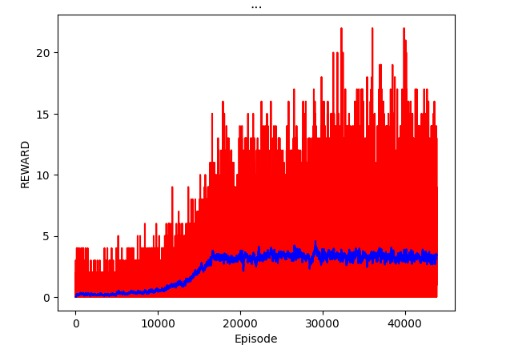



Links for the videos of our model:

First video:
https://youtube.com/shorts/uNPBAG_kQbE?feature=share

Second video:
https://youtube.com/shorts/W9FQZIPX8DA?si=sm00eUzDS_uKZhlB
